In [29]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
cd drive

/content/drive


In [32]:
cd My Drive

/content/drive/My Drive


In [268]:
%ls pyghack_data/

champaign_county_demographicscovid.csv    land_area.csv
champaign_data.py                         mask-use-by-county.csv
Champaign_zipcode_demographics.csv        PopulationEstimates.csv
Champaign_zipcode.gsheet                  PovertyEstimates.csv
Education.csv                             Unemployment.csv
final_county_features.csv                 us-counties_covid19.csv
il.1990_2018.19ages.txt                   us-counties_coviddeaths.csv
il-covid-counts-by-zipcode-9_24_2020.csv  us_pop_data.csv
illinois_population.csv


In [34]:
df_unem = pd.read_csv('pyghack_data/Unemployment.csv')
df_unem = df_unem[['FIPStxt','Unemployment_rate_2019','Median_Household_Income_2018']]

In [35]:
df_poverty = pd.read_csv('/content/drive/My Drive/pyghack_data/PovertyEstimates.csv')
df_poverty = df_poverty[['FIPStxt','PCTPOVALL_2018']]

In [36]:
df_edu = pd.read_csv('/content/drive/My Drive/pyghack_data/Education.csv')

In [37]:
df_edu.rename(columns = {'FIPS Code':'FIPStxt'}, inplace = True)

In [38]:
df_land = pd.read_csv('/content/drive/My Drive/pyghack_data/land_area.csv')

In [39]:
df_tpop = pd.read_csv('/content/drive/My Drive/pyghack_data/PopulationEstimates.csv')

In [40]:
df_features1 = df_unem
df_features1 = pd.merge(df_features1,df_poverty,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_edu,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_land,how='inner', on ='FIPStxt')
df_features1 = pd.merge(df_features1,df_tpop,how='inner', on ='FIPStxt')
df_features1.pop('Unnamed: 2')
df_features1.rename(columns = {'FIPStxt':'fips','Unemployment_rate_2019':'Unemployment_rate','Median_Household_Income_2018':'Median_Household_Income','PCTPOVALL_2018':'poverty_rate','POP_ESTIMATE_2019':'total_pop'}, inplace = True)
df_features1['Median_Household_Income']=df_features1['Median_Household_Income'].apply(lambda x: ''.join(c for c in x if c.isnumeric()))
df_features1['total_pop']=df_features1['total_pop'].apply(lambda x: ''.join(c for c in x if c.isnumeric()))
df_features1 = df_features1.astype({'fips':int, 'Unemployment_rate':float, 'Median_Household_Income':float,
       'poverty_rate':float, 'no_edu':float, 'high_school':float, 'college_drop':float, 'college':float, 'land_area':float, 'total_pop':float})
df_features1['pop_density'] = df_features1['total_pop']/df_features1['land_area']

In [41]:
df_features1

,fips,Unemployment_rate,Median_Household_Income,poverty_rate,no_edu,high_school,college_drop,college,land_area,total_pop,pop_density
0,0,3.7,61937.0,13.1,12.3,27.1,29.0,31.5,3531905.43,328239523.0,92.935536
1,1000,3.0,49881.0,16.8,14.2,30.9,29.9,24.9,50645.33,4903185.0,96.814158
2,1001,2.7,59338.0,13.8,11.3,32.6,28.4,27.7,594.44,55869.0,93.985936
3,1003,2.7,57588.0,9.8,9.7,27.6,31.3,31.3,1589.78,223234.0,140.418171
4,1005,3.8,34382.0,30.9,27.0,35.7,25.1,12.2,884.88,24686.0,27.897568
...,...,...,...,...,...,...,...,...,...,...,...
3186,56037,3.9,73315.0,8.4,9.0,33.3,35.7,22.0,10426.65,42343.0,4.061036
3187,56039,2.7,99087.0,6.3,5.6,13.2,23.8,57.4,3995.38,23464.0,5.872783
3188,56041,3.9,63401.0,10.0,7.2,40.1,37.2,15.4,2081.26,20226.0,9.718152
3189,56043,3.9,55190.0,11.9,10.4,30.3,37.7,21.5,2238.55,7805.0,3.486632


In [42]:
maskdf = pd.read_csv('/content/drive/My Drive/pyghack_data/mask-use-by-county.csv')
maskdf = maskdf.rename(columns={"COUNTYFP": "fips"})
maskdf['fips'] = maskdf['fips'].astype(int)
cdeath_df = pd.read_csv('/content/drive/My Drive/pyghack_data/us-counties_coviddeaths.csv')
coviddf = cdeath_df.merge(maskdf, on=['fips'],how='inner')
coviddf['fips'] = coviddf['fips'].astype(int)
coviddf = coviddf.drop(columns=['date'])
coviddf.pop('county')
coviddf.pop('state')
coviddf['no_mask']=coviddf['NEVER']+coviddf['RARELY']

In [43]:
df_features2 = pd.merge(df_features1,coviddf,how='inner', on ='fips')

In [44]:
df_features2['death_rate'] = df_features2['deaths']/df_features2['total_pop']

In [45]:
df_features2

,fips,Unemployment_rate,Median_Household_Income,poverty_rate,no_edu,high_school,college_drop,college,land_area,total_pop,pop_density,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,no_mask,death_rate
0,1001,2.7,59338.0,13.8,11.3,32.6,28.4,27.7,594.44,55869.0,93.985936,1738,25.0,1565.0,24.0,173.0,1.0,0.053,0.074,0.134,0.295,0.444,0.127,0.000447
1,1003,2.7,57588.0,9.8,9.7,27.6,31.3,31.3,1589.78,223234.0,140.418171,5165,50.0,4979.0,46.0,186.0,4.0,0.083,0.059,0.098,0.323,0.436,0.142,0.000224
2,1005,3.8,34382.0,30.9,27.0,35.7,25.1,12.2,884.88,24686.0,27.897568,857,7.0,657.0,7.0,200.0,0.0,0.067,0.121,0.120,0.201,0.491,0.188,0.000284
3,1007,3.1,46064.0,21.8,16.8,47.3,24.4,11.5,622.58,22394.0,35.969675,642,10.0,611.0,6.0,31.0,4.0,0.020,0.034,0.096,0.278,0.572,0.054,0.000447
4,1009,2.7,50412.0,13.2,19.8,34.0,33.5,12.6,644.78,57826.0,89.683303,1594,15.0,1236.0,15.0,358.0,0.0,0.053,0.114,0.180,0.194,0.459,0.167,0.000259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3119,56037,3.9,73315.0,8.4,9.0,33.3,35.7,22.0,10426.65,42343.0,4.061036,328,2.0,310.0,NaN,18.0,NaN,0.061,0.295,0.230,0.146,0.268,0.356,0.000047
3120,56039,2.7,99087.0,6.3,5.6,13.2,23.8,57.4,3995.38,23464.0,5.872783,529,1.0,496.0,NaN,33.0,NaN,0.095,0.157,0.160,0.247,0.340,0.252,0.000043
3121,56041,3.9,63401.0,10.0,7.2,40.1,37.2,15.4,2081.26,20226.0,9.718152,347,2.0,283.0,NaN,64.0,NaN,0.098,0.278,0.154,0.207,0.264,0.376,0.000099
3122,56043,3.9,55190.0,11.9,10.4,30.3,37.7,21.5,2238.55,7805.0,3.486632,112,6.0,103.0,NaN,9.0,NaN,0.204,0.155,0.069,0.285,0.287,0.359,0.000769


In [342]:
df_hr_uspop = pd.read_csv('/content/drive/My Drive/pyghack_data/us_pop_data.csv')
df_hr_uspop.pop('non-hispanic')
df_hr_uspop.pop('population')
df_hr_uspop.rename(columns = {'county':'fips','asian / pacific islander':'asian','amerian indian/alaska native':'native','PCTPOVALL_2018':'poverty_rate','POP_ESTIMATE_2019':'total_pop'}, inplace = True)
df_hr_uspop.keys()
df_feat = pd.merge(df_features2,df_hr_uspop,how='inner', on ='fips')
df_feat=df_feat[df_feat['deaths']>0]
df_feat['no_edu']=df_feat['no_edu']/100
df_feat['high_school']=df_feat['high_school']/100
df_feat['college_drop']=df_feat['college_drop']/100
df_feat['college']=df_feat['college']/100
df_feat['death_rate']=-np.log(df_feat['death_rate'])

In [343]:
df_feat.keys()

Index(['fips', 'Unemployment_rate', 'Median_Household_Income', 'poverty_rate',
       'no_edu', 'high_school', 'college_drop', 'college', 'land_area',
       'total_pop', 'pop_density', 'cases', 'deaths', 'confirmed_cases',
       'confirmed_deaths', 'probable_cases', 'probable_deaths', 'NEVER',
       'RARELY', 'SOMETIMES', 'FREQUENTLY', 'ALWAYS', 'no_mask', 'death_rate',
       'black', 'white', 'asian', 'native', 'hispanic', '0', '0-4', '12-16',
       '16-20', '20-24', '24-28', '28-32', '32-36', '36-40', '4-8', '40-44',
       '44-48', '48-52', '52-56', '56-60', '60-64', '64-68', '68-72', '8-12',
       'Female', 'Male'],
      dtype='object')

In [345]:
df_feat.head()

,fips,Unemployment_rate,Median_Household_Income,poverty_rate,no_edu,high_school,college_drop,college,land_area,total_pop,pop_density,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,no_mask,death_rate,black,white,asian,native,hispanic,0,0-4,12-16,16-20,20-24,24-28,28-32,32-36,36-40,4-8,40-44,44-48,48-52,52-56,56-60,60-64,64-68,68-72,8-12,Female,Male
0,1001,2.7,59338.0,13.8,0.113,0.326,0.284,0.277,594.44,55869.0,93.985936,1738,25.0,1565.0,24.0,173.0,1.0,0.053,0.074,0.134,0.295,0.444,0.127,7.711889,0.202047,0.777900,0.015162,0.004892,0.029658,0.011636,0.048866,0.067535,0.057067,0.066635,0.062247,0.065251,0.065035,0.071330,0.061564,0.068542,0.070628,0.058218,0.046564,0.041564,0.031276,0.020557,0.015665,0.069819,0.514487,0.485513
1,1003,2.7,57588.0,9.8,0.097,0.276,0.313,0.313,1589.78,223234.0,140.418171,5165,50.0,4979.0,46.0,186.0,4.0,0.083,0.059,0.098,0.323,0.436,0.142,8.403953,0.093192,0.884649,0.013462,0.008696,0.046468,0.010343,0.044491,0.059315,0.050949,0.057201,0.055302,0.060343,0.059063,0.066328,0.058719,0.065324,0.072213,0.071851,0.065438,0.057201,0.038826,0.023227,0.019741,0.064127,0.515384,0.484616
2,1005,3.8,34382.0,30.9,0.270,0.357,0.251,0.122,884.88,24686.0,27.897568,857,7.0,657.0,7.0,200.0,0.0,0.067,0.121,0.120,0.201,0.491,0.188,8.168081,0.491861,0.494273,0.006632,0.007234,0.042764,0.010289,0.041317,0.058318,0.059162,0.072184,0.067119,0.061533,0.058277,0.065271,0.058197,0.064427,0.067320,0.061734,0.061895,0.053736,0.036454,0.023150,0.018970,0.060649,0.472168,0.527832
3,1007,3.1,46064.0,21.8,0.168,0.473,0.244,0.115,622.58,22394.0,35.969675,642,10.0,611.0,6.0,31.0,4.0,0.020,0.034,0.096,0.278,0.572,0.054,7.713963,0.217054,0.774509,0.004018,0.004420,0.026250,0.010982,0.046384,0.056696,0.058170,0.077054,0.071473,0.067500,0.064286,0.071339,0.052277,0.070580,0.068482,0.060848,0.052768,0.044286,0.032634,0.018839,0.016205,0.059196,0.467813,0.532188
4,1009,2.7,50412.0,13.2,0.198,0.340,0.335,0.126,644.78,57826.0,89.683303,1594,15.0,1236.0,15.0,358.0,0.0,0.053,0.114,0.180,0.194,0.459,0.167,8.257144,0.019225,0.968568,0.005187,0.007019,0.095712,0.011705,0.048115,0.063416,0.054945,0.061618,0.058264,0.060754,0.061428,0.067790,0.062846,0.067376,0.068240,0.063676,0.056743,0.051193,0.034059,0.022528,0.017842,0.067462,0.507261,0.492739


In [346]:
train_dataset = df_feat.sample(frac=0.8,random_state=0)
test_dataset = df_feat.drop(train_dataset.index)

train_label = train_dataset['death_rate']
test_label = test_dataset['death_rate']

train_nmlabel = train_dataset['no_mask']
test_nmlabel = test_dataset['no_mask']


train_dataset = train_dataset[['Unemployment_rate', 'Median_Household_Income',
       'no_edu', 'high_school', 'college_drop', 'college',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic',
       'Female', 'Male']]
test_dataset = test_dataset[['Unemployment_rate', 'Median_Household_Income',
       'no_edu', 'high_school', 'college_drop', 'college',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic',
       'Female', 'Male']]

df_trim = df_feat[['Unemployment_rate', 'Median_Household_Income',
       'no_edu', 'high_school', 'college_drop', 'college',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic',
       'Female', 'Male']]

In [347]:
train_stats = df_trim.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Unemployment_rate,2602.0,4.006687,1.374128,1.400000,3.100000,3.700000,4.600000,1.830000e+01
Median_Household_Income,2602.0,53118.688317,14392.077123,25385.000000,43504.000000,50738.000000,59356.000000,1.403820e+05
no_edu,2602.0,0.138490,0.063797,0.012000,0.091000,0.126000,0.178000,6.630000e-01
high_school,2602.0,0.340961,0.072259,0.055000,0.296000,0.343500,0.392000,5.350000e-01
college_drop,2602.0,0.302771,0.049085,0.058000,0.270000,0.303000,0.336000,4.610000e-01
college,2602.0,0.217767,0.097270,0.067000,0.148000,0.192000,0.263000,7.850000e-01
total_pop,2602.0,120950.289393,355568.255573,404.000000,15891.250000,34012.000000,88698.500000,1.003911e+07
pop_density,2602.0,259.225514,886.375629,0.035944,24.890495,56.969906,151.774598,1.880838e+04
black,2602.0,0.114563,0.154408,0.002206,0.015621,0.042392,0.146122,8.659187e-01
white,2602.0,0.843833,0.164926,0.092288,0.783577,0.912563,0.959957,9.911472e-01


In [348]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
train_dataset = norm(train_dataset)
test_dataset = norm(test_dataset)
train_stats2 = train_dataset.describe()
train_stats2 = train_stats2.transpose()
train_stats2

,count,mean,std,min,25%,50%,75%,max
Unemployment_rate,2082.0,-0.002175,0.982283,-1.896975,-0.659827,-0.150413,0.431774,9.019035
Median_Household_Income,2082.0,-0.003497,0.994755,-1.927011,-0.670868,-0.166945,0.429112,6.063288
no_edu,2082.0,-0.017997,0.971766,-1.982693,-0.744388,-0.195772,0.584047,5.431462
high_school,2082.0,-0.002688,1.012486,-3.957431,-0.636055,0.035140,0.716714,2.519253
college_drop,2082.0,0.006917,0.988465,-3.601322,-0.647264,0.004666,0.676969,3.223572
college,2082.0,0.010335,1.005474,-1.529426,-0.706974,-0.249485,0.485581,5.831516
total_pop,2082.0,0.010233,1.045793,-0.336364,-0.295398,-0.243936,-0.092238,27.893819
pop_density,2082.0,-0.004002,0.965404,-0.292415,-0.264252,-0.229023,-0.122097,20.926974
black,2082.0,-0.003605,0.999344,-0.727663,-0.642303,-0.468552,0.175725,4.866038
white,2082.0,-0.004227,1.004689,-4.556868,-0.361768,0.416152,0.703208,0.893215


In [349]:
def build_model_DNN(input_len):
  model = keras.Sequential([
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu',input_shape=[8,1]),
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu'),
    # layers.Conv1D(filters=16, kernel_size=3,activation='relu'),
    # layers.MaxPooling1D(),
    # layers.Flatten(),
    layers.Dense(64, activation='relu',input_shape=[input_len]),
    # layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    # layers.Dropout(0.25),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse','msle','mape','kullback_leibler_divergence'])
  return model

In [350]:
print(len(train_dataset.keys()))
model = build_model_DNN(len(train_dataset.keys()))

15


In [351]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_70 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_25 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_26 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_72 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 64)              

In [352]:
EPOCHS = 200
# train_array = np.array(train_dataset.to_numpy())
history = model.fit(
  train_dataset, train_label,batch_size=16,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/200
105/105 [==============================] - 0s 4ms/step - loss: 24.0172 - mae: 3.9332 - mse: 24.0172 - msle: 0.9894 - mape: 48.4496 - kullback_leibler_divergence: 0.7546 - val_loss: 3.8245 - val_mae: 1.5309 - val_mse: 3.8245 - val_msle: 0.0507 - val_mape: 19.1196 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 4.3693 - mae: 1.6502 - mse: 4.3693 - msle: 0.0583 - mape: 20.6574 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 2.2232 - val_mae: 1.1799 - val_mse: 2.2232 - val_msle: 0.0278 - val_mape: 14.6403 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 3.1831 - mae: 1.3970 - mse: 3.1831 - msle: 0.0417 - mape: 17.4937 - kullback_leibler_divergence: 0.0000e+00 - val_loss: 1.5381 - val_mae: 0.9850 - val_mse: 1.5381 - val_msle: 0.0182 - val_mape: 12.3802 - val_kullback_leibler_divergence: 0.0000e+00
Epoch 4/200
105/105 [============

In [353]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,msle,mape,kullback_leibler_divergence,val_loss,val_mae,val_mse,val_msle,val_mape,val_kullback_leibler_divergence,epoch
195,0.484130,0.551296,0.484130,0.005854,6.854500,0.0,0.743939,0.669625,0.743939,0.008643,8.255915,0.0,195
196,0.468728,0.534395,0.468728,0.005684,6.651054,0.0,0.751396,0.674863,0.751396,0.008699,8.249805,0.0,196
197,0.477296,0.541698,0.477296,0.005839,6.766515,0.0,0.742219,0.663428,0.742219,0.008590,8.163472,0.0,197
198,0.454299,0.528529,0.454299,0.005527,6.585830,0.0,0.755486,0.675023,0.755486,0.008782,8.227468,0.0,198
199,0.481015,0.537722,0.481015,0.005885,6.702521,0.0,0.760439,0.674248,0.760439,0.008781,8.282814,0.0,199


In [354]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [mse]')
  plt.ylabel('Error [mse]')
  plt.legend()
  plt.grid(True)

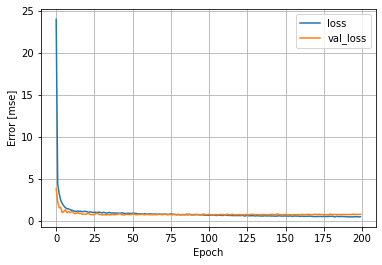

In [355]:
plot_loss(history)

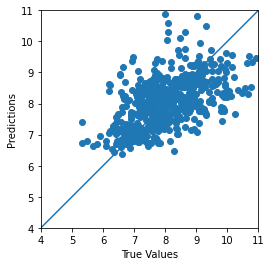

In [359]:
test_predictions = model.predict(test_dataset,batch_size=512).flatten()
test_pred=(test_predictions).flatten()
test_lab=(test_label).to_numpy().flatten()
test_pred[test_pred<0]=0
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [4, 11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

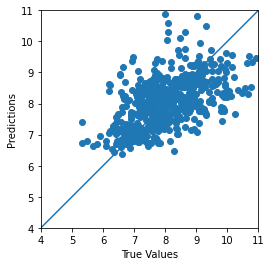

In [361]:
test_predictions = model.predict(test_dataset,batch_size=512).flatten()
test_pred=(test_predictions).flatten()
test_lab=(test_label).to_numpy().flatten()
test_pred[test_pred<0]=0
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [4, 11]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

No handles with labels found to put in legend.


Text(0, 0.5, 'ML output')

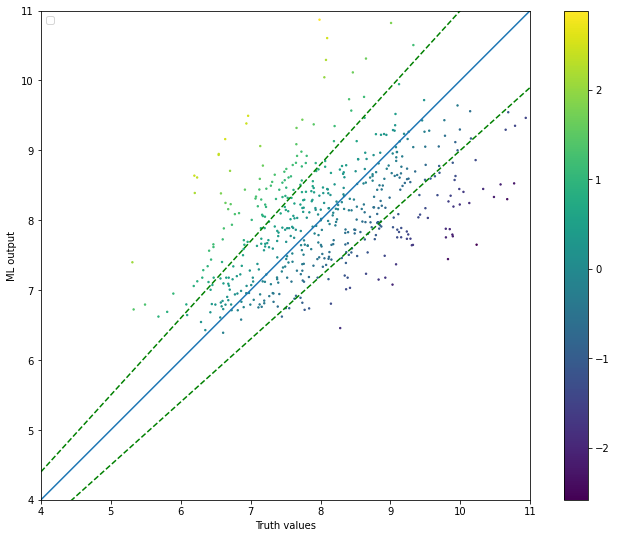

In [363]:
from scipy.optimize import curve_fit
fig = plt.figure(figsize=(12, 9))
def line(x,m,c):
    return (m*x)+c
popt, pcov = curve_fit(line, test_lab, test_pred)
x_points = np.linspace(0, 11, 1000)
error = (test_pred - test_lab)
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,c=error,s=2 )
plt.colorbar()
lims = [4, 11]
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)
_ = plt.plot(lims, [4.4,12.1],'g--')
_ = plt.plot(lims, [3.6,9.9],'g--')
# _ =plt.plot(x_points, line(x_points, *popt), 'r-', label='ML fit: m=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
plt.xlabel('Truth values')
plt.ylabel('ML output')

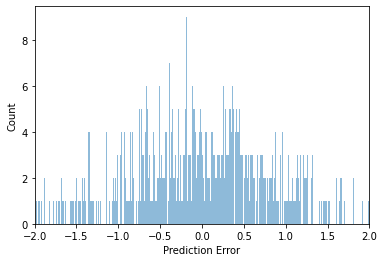

In [366]:
error = (test_pred - test_lab)
plt.hist(error, bins = 400, alpha=0.5)
plt.xlabel("Prediction Error")
# plt.yscale('log')
plt.xlim((-2,2))
_ = plt.ylabel("Count")

<ErrorbarContainer object of 3 artists>

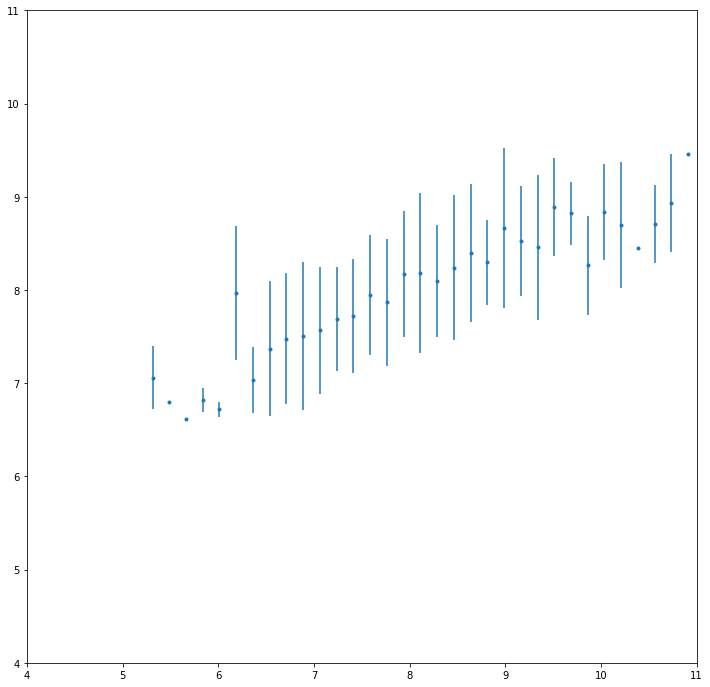

In [370]:
import scipy.stats
import numpy
import matplotlib.pyplot as plt

x = test_lab
y = test_pred
fig = plt.figure(figsize=(12, 12))
means_result = scipy.stats.binned_statistic(x, [y, y**2], bins=40,range=(4,11), statistic='mean')
means, means2 = means_result.statistic
standard_deviations = numpy.sqrt(means2 - means**2)
bin_edges = means_result.bin_edges
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.xlim((4,11))
plt.ylim((4,11))
plt.errorbar(x=bin_centers, y=means, yerr=standard_deviations, linestyle='none', marker='.')


(6.0, 11.0)

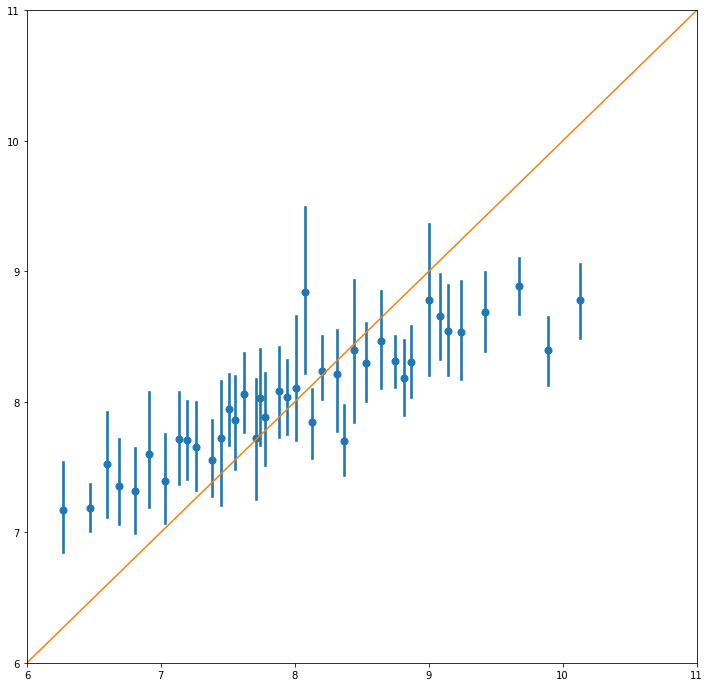

In [372]:
fig = plt.figure(figsize=(12, 12))
sns.regplot(x=test_lab, y=test_pred, x_bins=40, fit_reg=None)
lims=(6,11)
_ = plt.plot(lims, lims)
plt.xlim((lims))
plt.ylim((lims))

In [373]:
df_cuzip = pd.read_csv('/content/drive/My Drive/pyghack_data/Champaign_zipcode_demographics.csv')
df_cuzip.loc[(df_cuzip.Unemployment_rate==-1),'Unemployment_rate']=0
df_cuzip.rename(columns = {'male':'Male','female':'Female','population':'total_pop','median_household_income':'Median_Household_Income'}, inplace = True)

In [374]:
df_cuzip.keys()

Index(['zipcode', 'city', 'total_pop', 'pop_density',
       'Median_Household_Income', 'Male', 'Female', 'white', 'black', 'native',
       'asian', 'hispanic', 'Unemployment_rate', 'no_edu', 'high_school',
       'college_drop', 'college', 'poverty_rate'],
      dtype='object')

In [375]:
df_cuzip_test = df_cuzip[['Unemployment_rate', 'Median_Household_Income',
       'no_edu', 'high_school', 'college_drop', 'college',
       'total_pop', 'pop_density','black', 'white', 'asian', 'native', 'hispanic',
       'Female', 'Male']]
df_cuzip_test['no_edu']=df_cuzip_test['no_edu']/100
df_cuzip_test['high_school']=df_cuzip_test['high_school']/100
df_cuzip_test['college_drop']=df_cuzip_test['college_drop']/100
df_cuzip_test['college']=df_cuzip_test['college']/100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [378]:
df_cuzip_test=df_cuzip_test[df_cuzip_test['Unemployment_rate']>-1]
df_cuzip_test = norm(df_cuzip_test)

In [379]:
cu_predictions = model.predict(df_cuzip_test,batch_size=8)
cu_predictions = np.exp(-cu_predictions)

In [380]:
df_cuzip['estimated_death_rate']=cu_predictions
df_cuzip['estimated_deaths']=df_cuzip['estimated_death_rate']*df_cuzip['total_pop']

In [381]:
df_cuzip

,zipcode,city,total_pop,pop_density,Median_Household_Income,Male,Female,white,black,native,asian,hispanic,Unemployment_rate,no_edu,high_school,college_drop,college,poverty_rate,estimated_death_rate,estimated_deaths
0,60949,ludlow,636,25,32303.0,0.49,0.51,0.926,0.020,0.000,0.016,0.014,8,18.0,65.0,10.0,8.0,NaN,0.000622,0.395428
1,61801,urbana,30937,5780,25647.0,0.51,0.49,0.592,0.140,0.002,0.214,0.021,2,6.0,28.0,3.0,61.0,NaN,0.000662,20.465089
2,61802,urbana,19052,230,43767.0,0.48,0.52,0.698,0.180,0.005,0.053,0.033,4,10.0,50.0,5.0,34.0,NaN,0.000958,18.258243
3,61815,bondville,228,779,35500.0,0.46,0.54,0.996,0.000,0.000,0.000,0.000,0,6.8,78.9,8.7,5.6,NaN,0.000152,0.034736
4,61816,broadlands,509,18,71000.0,0.50,0.50,0.967,0.004,0.000,0.002,0.002,0,4.8,62.7,4.8,27.6,NaN,0.000150,0.076225
5,61820,champaign,36964,5656,22470.0,0.54,0.46,0.671,0.137,0.002,0.122,0.040,2,8.0,36.0,5.0,52.0,NaN,0.000423,15.618358
6,61821,champaign,30174,3999,52152.0,0.48,0.52,0.670,0.219,0.003,0.056,0.021,3,5.0,43.0,8.0,43.0,NaN,0.001268,38.260435
7,61822,champaign,21608,199,77005.0,0.49,0.51,0.748,0.082,0.002,0.130,0.009,2,3.0,32.0,10.0,56.0,NaN,0.000068,1.466286
8,61840,dewey,709,21,71087.0,0.50,0.50,0.979,0.007,0.003,0.001,0.001,0,0.0,62.0,14.0,20.0,NaN,0.000151,0.107185
9,61843,fisher,2363,62,57885.0,0.50,0.50,0.979,0.001,0.001,0.003,0.007,4,6.0,65.0,13.0,16.0,NaN,0.000211,0.498519


In [304]:
df_cuzip

,zipcode,city,total_pop,pop_density,Median_Household_Income,Male,Female,white,black,native,asian,hispanic,Unemployment_rate,no_edu,high_school,college_drop,college,poverty_rate,estimated_deaths
0,60949,ludlow,636,25,32303.0,0.49,0.51,0.926,0.020,0.000,0.016,0.014,8,18.0,65.0,10.0,8.0,NaN,14.923872
1,61801,urbana,30937,5780,25647.0,0.51,0.49,0.592,0.140,0.002,0.214,0.021,2,6.0,28.0,3.0,61.0,NaN,65.871651
2,61802,urbana,19052,230,43767.0,0.48,0.52,0.698,0.180,0.005,0.053,0.033,4,10.0,50.0,5.0,34.0,NaN,25.337807
3,61815,bondville,228,779,35500.0,0.46,0.54,0.996,0.000,0.000,0.000,0.000,0,6.8,78.9,8.7,5.6,NaN,33.545132
4,61816,broadlands,509,18,71000.0,0.50,0.50,0.967,0.004,0.000,0.002,0.002,0,4.8,62.7,4.8,27.6,NaN,20.950781
5,61820,champaign,36964,5656,22470.0,0.54,0.46,0.671,0.137,0.002,0.122,0.040,2,8.0,36.0,5.0,52.0,NaN,8.395907
6,61821,champaign,30174,3999,52152.0,0.48,0.52,0.670,0.219,0.003,0.056,0.021,3,5.0,43.0,8.0,43.0,NaN,47.270782
7,61822,champaign,21608,199,77005.0,0.49,0.51,0.748,0.082,0.002,0.130,0.009,2,3.0,32.0,10.0,56.0,NaN,36.904976
8,61840,dewey,709,21,71087.0,0.50,0.50,0.979,0.007,0.003,0.001,0.001,0,0.0,62.0,14.0,20.0,NaN,18.528601
9,61843,fisher,2363,62,57885.0,0.50,0.50,0.979,0.001,0.001,0.003,0.007,4,6.0,65.0,13.0,16.0,NaN,14.067974


In [376]:
np.log(10)

2.302585092994046

In [377]:
np.exp(2.302585092994046)

10.000000000000002

In [382]:
model2 = build_model_DNN(len(train_dataset.keys()))
model2.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_75 (Dense)             (None, 64)                1024      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_76 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_30 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)              

In [384]:
EPOCHS = 200
# train_array = np.array(train_dataset.to_numpy())
history = model2.fit(
  train_dataset, train_nmlabel,batch_size=16,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/200
105/105 [==============================] - 0s 4ms/step - loss: 0.0135 - mae: 0.0863 - mse: 0.0135 - msle: 0.0088 - mape: 140.0234 - kullback_leibler_divergence: 0.1169 - val_loss: 0.0054 - val_mae: 0.0571 - val_mse: 0.0054 - val_msle: 0.0039 - val_mape: 84.5244 - val_kullback_leibler_divergence: 0.0184
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0076 - mae: 0.0676 - mse: 0.0076 - msle: 0.0054 - mape: 112.3254 - kullback_leibler_divergence: 0.0365 - val_loss: 0.0052 - val_mae: 0.0576 - val_mse: 0.0052 - val_msle: 0.0038 - val_mape: 83.3358 - val_kullback_leibler_divergence: 0.0052
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 0.0069 - mae: 0.0646 - mse: 0.0069 - msle: 0.0049 - mape: 116.5314 - kullback_leibler_divergence: 0.0293 - val_loss: 0.0048 - val_mae: 0.0544 - val_mse: 0.0048 - val_msle: 0.0035 - val_mape: 75.7718 - val_kullback_leibler_divergence: 0.0202
Epoch 4/200
105/105 [==============================]

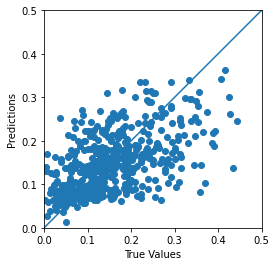

In [386]:
test_predictions = model2.predict(test_dataset,batch_size=512).flatten()
test_pred=(test_predictions).flatten()
test_lab=(test_nmlabel).to_numpy().flatten()
test_pred[test_pred<0]=0
a = plt.axes(aspect='equal')
plt.scatter(test_lab, test_pred,)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [0,0.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

(0.0, 0.5)

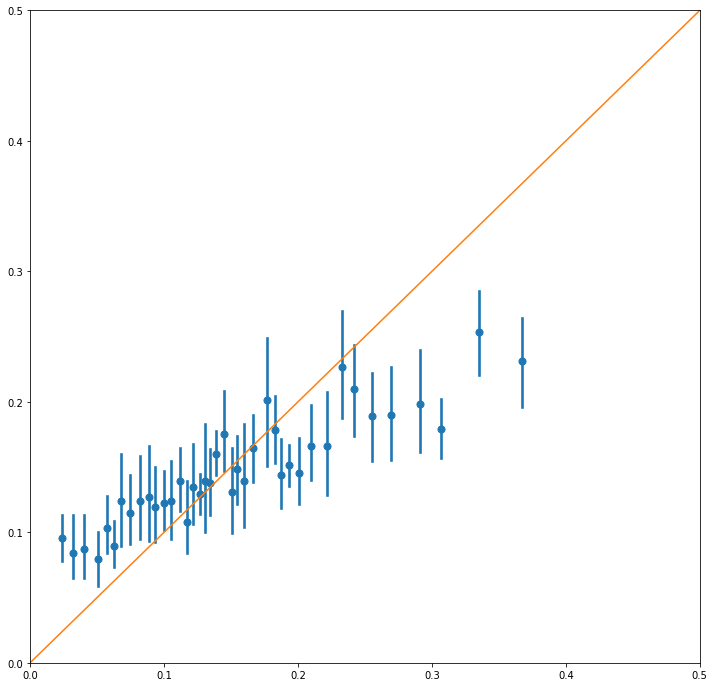

In [387]:
fig = plt.figure(figsize=(12, 12))
sns.regplot(x=test_lab, y=test_pred, x_bins=40, fit_reg=None)
lims=(0,0.5)
_ = plt.plot(lims, lims)
plt.xlim((lims))
plt.ylim((lims))

In [388]:
cu_predictions2 = model2.predict(df_cuzip_test,batch_size=8)
df_cuzip['no_mask_rate']=cu_predictions2

In [389]:
df_cuzip

,zipcode,city,total_pop,pop_density,Median_Household_Income,Male,Female,white,black,native,asian,hispanic,Unemployment_rate,no_edu,high_school,college_drop,college,poverty_rate,estimated_death_rate,estimated_deaths,no_mask_rate
0,60949,ludlow,636,25,32303.0,0.49,0.51,0.926,0.020,0.000,0.016,0.014,8,18.0,65.0,10.0,8.0,NaN,0.000622,0.395428,0.126365
1,61801,urbana,30937,5780,25647.0,0.51,0.49,0.592,0.140,0.002,0.214,0.021,2,6.0,28.0,3.0,61.0,NaN,0.000662,20.465089,0.080009
2,61802,urbana,19052,230,43767.0,0.48,0.52,0.698,0.180,0.005,0.053,0.033,4,10.0,50.0,5.0,34.0,NaN,0.000958,18.258243,0.082372
3,61815,bondville,228,779,35500.0,0.46,0.54,0.996,0.000,0.000,0.000,0.000,0,6.8,78.9,8.7,5.6,NaN,0.000152,0.034736,0.212795
4,61816,broadlands,509,18,71000.0,0.50,0.50,0.967,0.004,0.000,0.002,0.002,0,4.8,62.7,4.8,27.6,NaN,0.000150,0.076225,0.200410
5,61820,champaign,36964,5656,22470.0,0.54,0.46,0.671,0.137,0.002,0.122,0.040,2,8.0,36.0,5.0,52.0,NaN,0.000423,15.618358,0.096495
6,61821,champaign,30174,3999,52152.0,0.48,0.52,0.670,0.219,0.003,0.056,0.021,3,5.0,43.0,8.0,43.0,NaN,0.001268,38.260435,0.076782
7,61822,champaign,21608,199,77005.0,0.49,0.51,0.748,0.082,0.002,0.130,0.009,2,3.0,32.0,10.0,56.0,NaN,0.000068,1.466286,0.048956
8,61840,dewey,709,21,71087.0,0.50,0.50,0.979,0.007,0.003,0.001,0.001,0,0.0,62.0,14.0,20.0,NaN,0.000151,0.107185,0.309273
9,61843,fisher,2363,62,57885.0,0.50,0.50,0.979,0.001,0.001,0.003,0.007,4,6.0,65.0,13.0,16.0,NaN,0.000211,0.498519,0.098446
